In [1]:
# Preliminaries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from scipy import optimize
import theano.tensor as tt

# Alchemical free energy dataset

We first process the alchemical free energy dataset generated via FEP+

In [2]:
# Load the data
def read_fep_data(filename):
    """
    Read experimental and calculated alchemical free energy data.
    
    Parameters
    ----------
    filename : str
        Input filename to read
                
                
    Returns
    -------
    DDG_exp : np.array of dimension [nmutations]
        DDG_exp[mutation] is the measured free energy difference for mutation 'mutation' (kcal/mol)
    DDG_calc : np.array of dimension [nmutations,nreplicates]
        DDG_calc[mutation,replicate] is the computed free energy difference for mutation 'mutation', replicate 'replicate' (kcal/mol)
    dDDG_calc : np.array of dimension [nmutations,nreplicates]
        dDDG_calc[mutation,replicate] is the estimated uncertainty in the computed free energy difference for mutation 'mutation', replicate 'replicate' (kcal/mol)
        
    """
    DDG_exp = list()
    DDG_calc = list()
    dDDG_calc = list()
    with open(filename, 'r') as input:
        for line in input:
            try:
                # Data format: 
                # Mutation, IC50 (nM), DDG_exp (kcal/mol), DDG_FEP_run1, cc_err_FEP_run1, DDG_FEP_run2, cc_err_FEP_run2, DDG_FEP_run3, cc_err_FEP_run3
                data = [ item.strip() for item in line.split() ]
                if len(data) < 9:  #vis. data for mutation is incomplete...
                    continue
                elif data[1] == '10000':  #vis. data is beyond the concentration limit of the assay...
                    continue
                else:
                    IC50 = float(data[1])
                    DDG_exp.append(float(data[2])) # kcal/mol
                    DDG_calc.append([float(data[i]) for i in [3,5,7]]) # kcal/mol
                    dDDG_calc.append([float(data[i]) for i in [4,6,8]]) # kcal/mol
            except:
                pass

    return np.array(DDG_exp), np.array(DDG_calc), np.array(dDDG_calc)



In [3]:
# Load the data
DDG_exp_obs, DDG_calc_obs, dDDG_calc_obs = read_fep_data('results/All_144_v173_all5ns.KeepLOD.dat')
[nmutants, nreplicates] = DDG_calc_obs.shape
print('There are %d mutants and %d computational replicates in the dataset' % (nmutants, nreplicates))

There are 142 mutants and 3 computational replicates in the dataset


Our estimate of the experimental error comes from the observed uncertainty-corrupted Kd-derived $\Delta \Delta G$ vs IC50-derived $\Delta \Delta G$ of 0.81 kcal/mol:

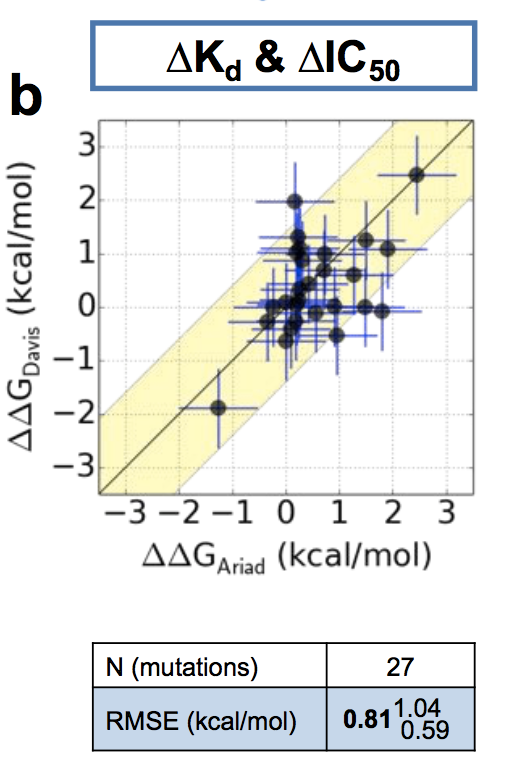

In [4]:
sigma_exp = np.sqrt(0.81**2 / 2) # RMSE of true Kd-derived DeltaG and IC50-derived DeltaG

# Bayesian analysis of experimental and computational mutation datasets

This notebook uses Bayesian inference to estimate the true error between experimental and computational free energies of mutation using a hierarchical model that makes very weak assumptions about the underlying distribution of mutations.

## Priors

We presume the true free energy differences of mutation $i$, $\Delta\Delta G^\mathrm{true}_i$, comes from a normal distribution of unknown mean and variance:
$$\Delta \Delta G^\mathrm{true}_i \sim \mathcal{N}(\mu_\mathrm{mut}, \sigma_\mathrm{mut}^2) \:\: i = 1, \ldots, M$$
where there are $M$ mutations under consideration.

We assign weak priors to the mean and variance
$$\mu_\mathrm{mut} \sim U(-6, +6)$$
$$\sigma_\mathrm{mut} \propto \sigma^{-1}$$
where we limit $\sigma < e^{-10}$.

## Unknown parameters

We presume the true computational predictions (absent statistical error) differ from the (unknown) true free energy difference of mutation $\Delta\Delta G^\mathrm{true}_i$ by normally-distributed errors with bias $b$ and standard error $\sigma_\mathrm{RMSE}$, the true RMSE of interest:
$$\Delta\Delta G_\mathrm{calc}^\mathrm{true} \sim \mathcal{N}(\Delta\Delta G^\mathrm{true}_i + b, \sigma_\mathrm{RMSE}^2)$$
We are interested in characterizing the true bias $b$ and standard error $\sigma$ of the method.


## Data likelihood

The experimental data we observe is corrupted by error (uncertainty), which we presume to be normally distributed with standard deviation $\sigma_\mathrm{exp}$:
$$\Delta\Delta G_\mathrm{exp} \sim \mathcal{N}(\Delta\Delta G_i, \sigma_\mathrm{exp}^2)$$

For alchemical free energy calculations, the computed free energy changes are also corrupted by statistical error, which we also presume to be normally distributed with standard deviation $\sigma_{\mathrm{calc},i}$:
$$\Delta\Delta G_{\mathrm{calc},i} \sim \mathcal{N}(\Delta\Delta G_i, \sigma_{\mathrm{calc},i}^2)$$
where $\sigma_{\mathrm{calc},i}$ is the statistical error estimate from each computational experimental replicate.

(We take $\sigma_\mathrm{calc} = 0$ for calculations that do not have a statistical component, like GBSA.)

In [5]:
# Build the Bayesian model for alchemical free energy calculations

fep_model = pm.Model()

with fep_model:
    # Priors on nuisance parameters (that will be marginalized out)
    mu_mut = pm.Uniform('mu_mut', -6, +6) # kcal/mol
    sigma_mut = pm.HalfFlat('sigma_mut', testval=1) # kcal/mol
    DDG_true = pm.Normal('DDG_true', mu=mu_mut, sd=sigma_mut, shape=nmutants)    
    
    # Priors on unknown values of interest
    RMSE_true = pm.HalfFlat('RMSE', testval=1) # kcal/mol, uninformative prior for nonnegative values of the RMSE
    MUE_true = pm.Deterministic('MUE', RMSE_true*np.sqrt(2.0/np.pi)) # store MUE estimate alongside RMSE using analytical relationship
    
    # Unknown true computed values
    DDG_calc_true = pm.Normal('DDG_calc_true', mu=(DDG_true), sd=RMSE_true, shape=nmutants)    
    
    # Data likelihood for observed data
    DDG_exp = pm.Normal('DDG_exp', mu=DDG_true, sd=sigma_exp, shape=nmutants, observed=DDG_exp_obs)
    DDG_calc = list()
    for replicate in range(nreplicates):
        DDG_calc.append(pm.Normal('DDG_calc_%d' % replicate, mu=DDG_calc_true, sd=dDDG_calc_obs[:,replicate], shape=nmutants, observed=DDG_calc_obs[:,replicate]))
    

In [6]:
# Sample from the posterior and plot the RMSE confidence interval
with fep_model:
    trace = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:14<00:00, 382.27it/s]


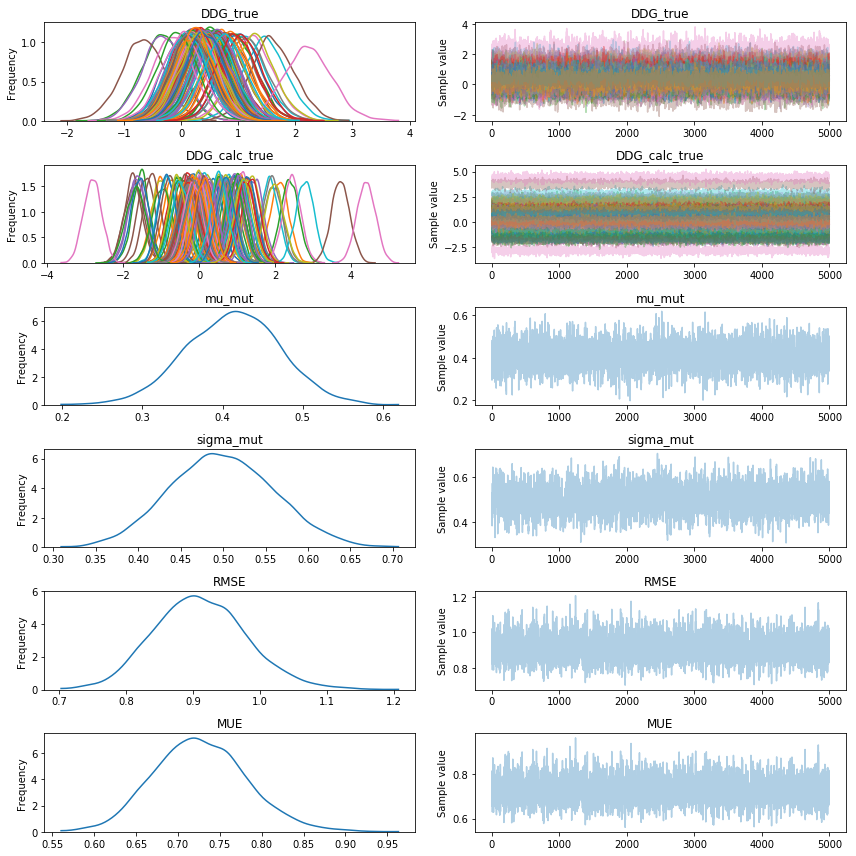

In [7]:
# Plot the posterior confidence interval for RMSE
_ = pm.traceplot(trace)

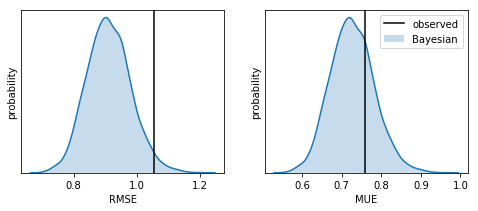

In [8]:
# Plot the Bayesian confidence intervals for the RMSE and MUE
plt.figure(figsize=[8,3]);

# RMSE
RMSE_obs = np.sqrt(np.mean((DDG_exp_obs - DDG_calc_obs.mean(1))**2))
plt.subplot(121);
sns.kdeplot(trace['RMSE'], shade=True);
plt.plot([RMSE_obs, RMSE_obs], [0, 10], 'k-');
#plt.legend(['observed', 'Bayesian']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);

# MUE
plt.subplot(122);
MUE_obs = np.mean(np.abs((DDG_exp_obs - DDG_calc_obs.mean(1))))
sns.kdeplot(trace['MUE'], shade=True);
plt.plot([MUE_obs, MUE_obs], [0, 10], 'k-');
plt.legend(['observed', 'Bayesian']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);   

In [9]:
def ci(xtrace, width=0.95):
    """
    Compute confidence interval
    """
    x = np.array(xtrace)
    x.sort()
    n = len(xtrace)
    low = int(n * (1-width)/2.0)
    high = int(n * (1 - (1-width)/2.0))    
    return x[low], x[high]

In [10]:
def show_statistics(trace):
    for statistic in ['RMSE', 'MUE']:
        x_t = np.array(trace[statistic])
        x_mean = x_t.mean()
        x_low, x_high = ci(x_t)
        print('True %s: %.3f [%.3f, %.3f] kcal/mol (95%% CI)' % (statistic, x_mean, x_low, x_high))

In [11]:
show_statistics(trace)

True RMSE: 0.911 [0.784, 1.055] kcal/mol (95% CI)
True MUE: 0.727 [0.626, 0.842] kcal/mol (95% CI)


# GBSA data analysis

In [12]:
# Read calculated GBSA data
def read_gbsa_data(filename):
    """
    Read experimental and calculated GBSA free energy data.
    
    Parameters
    ----------
    filename : str
        Input filename to read
                
                
    Returns
    -------
    DDG_exp : np.array of dimension [nmutations]
        DDG_exp[mutation] is the measured free energy difference for mutation 'mutation' (kcal/mol)
    DDG_calc : np.array of dimension [nmutations,nreplicates]
        DDG_calc[mutation] is the computed free energy difference for mutation 'mutation' (kcal/mol)
        
    """
    DDG_exp = list()
    DDG_calc = list()
    with open(filename, 'r') as input:
        for line in input:
            try:
                # Data format: 
                # DDG_exp (kcal/mol), DDG_prime (kcal/mol)
                data = [ item.strip() for item in line.split() ]
                if len(data) < 2:  #vis. data for mutation is incomplete...
                    continue
                if data[0] == '5.08' or data[0] == '2.33':  #vis. beyond concentration limit of assay
                    continue
                else:
                    DDG_exp.append(float(data[0])) # kcal/mol
                    DDG_calc.append(float(data[1])) # kcal/mol
            except:
                pass

    return np.array(DDG_exp), np.array(DDG_calc)

In [13]:
# Load the data
DDG_exp_obs, DDG_calc_obs = read_gbsa_data('results/All_144_Prime.dat')

print('There are %d mutants in the dataset' % (nmutants))

There are 142 mutants in the dataset


In [14]:
# Build the Bayesian model for GBSA calculations

sigma_exp = np.sqrt(0.81**2 / 2) # RMSE of true Kd-derived DeltaG and IC50-derived DeltaG

gbsa_model = pm.Model()

with gbsa_model:
    # Priors on nuisance parameters (that will be marginalized out)
    mu_mut = pm.Uniform('mu_mut', -6, +6) # kcal/mol
    sigma_mut = pm.HalfFlat('sigma_mut', testval=1) # kcal/mol
    DDG_true = pm.Normal('DDG_true', mu=mu_mut, sd=sigma_mut, shape=nmutants)    
    
    # Priors on unknown values of interest
    RMSE_true = pm.HalfFlat('RMSE', testval=1) # kcal/mol, uninformative prior for nonnegative values of the RMSE
    MUE_true = pm.Deterministic('MUE', RMSE_true*np.sqrt(2.0/np.pi)) # store MUE estimate alongside RMSE using analytical relationship
        
    # Data likelihood for observed data
    DDG_exp = pm.Normal('DDG_exp', mu=DDG_true, sd=sigma_exp, shape=nmutants, observed=DDG_exp_obs)
    DDG_calc_true = pm.Normal('DDG_calc_true', mu=(DDG_true), sd=RMSE_true, shape=nmutants, observed=DDG_calc_obs)        

In [15]:
# Sample from the posterior and plot the RMSE confidence interval
with gbsa_model:
    trace = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:17<00:00, 306.08it/s]


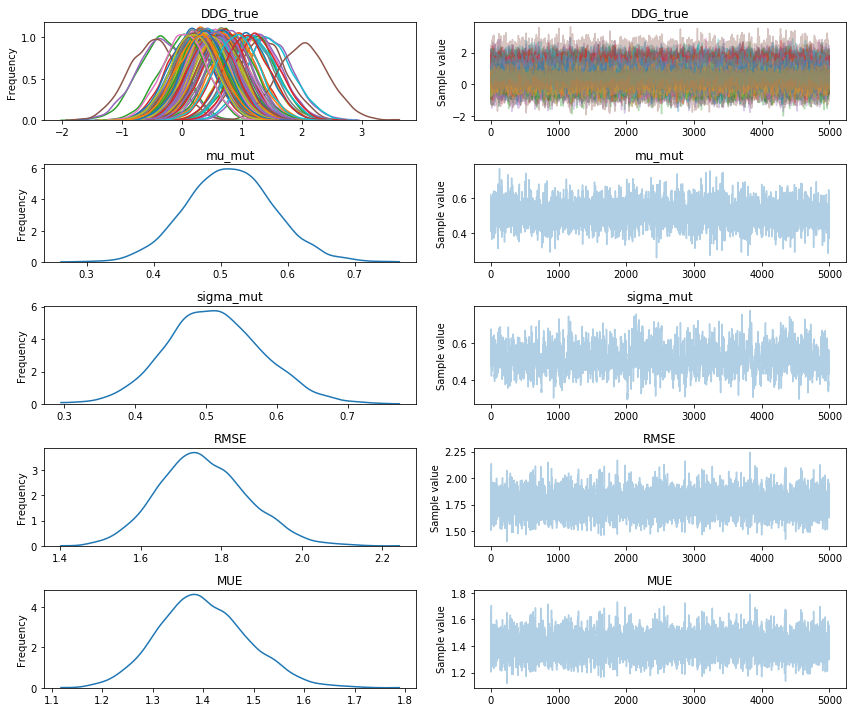

In [16]:
# Plot the posterior confidence interval for RMSE
_ = pm.traceplot(trace)

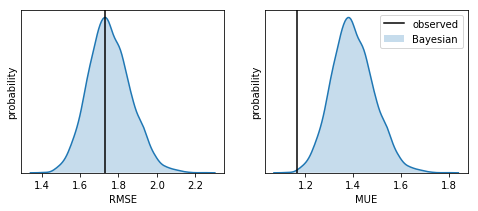

In [17]:
# Plot the Bayesian confidence intervals for the RMSE and MUE
plt.figure(figsize=[8,3]);

# RMSE
RMSE_obs = np.sqrt(np.mean((DDG_exp_obs - DDG_calc_obs)**2))
plt.subplot(121);
sns.kdeplot(trace['RMSE'], shade=True);
plt.plot([RMSE_obs, RMSE_obs], [0, 10], 'k-');
#plt.legend(['observed', 'Bayesian']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);

# MUE
plt.subplot(122);
MUE_obs = np.mean(np.abs((DDG_exp_obs - DDG_calc_obs)))
sns.kdeplot(trace['MUE'], shade=True);
plt.plot([MUE_obs, MUE_obs], [0, 10], 'k-');
plt.legend(['observed', 'Bayesian']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);   

In [18]:
show_statistics(trace)

True RMSE: 1.754 [1.551, 1.984] kcal/mol (95% CI)
True MUE: 1.400 [1.238, 1.583] kcal/mol (95% CI)


# How does the relationship between true and observed RMSE change as we add observation noise?

Let's use some realistic parameters from our distribution of $\Delta\Delta G_\mathrm{true}$ to simulate what happens to the true and observed RMSE/MUE as we add different levels of observation noise to experimental and computed $\Delta\Delta G$.

In [19]:
def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

def mue(x, y):
    return np.mean(abs(x-y))

def plot_statistics(rmse_true, sigma_exp, sigma_calc):
    """Compute sample statisics for synthetic datasets for given distribution parameters.
    
    Parameters
    ----------
    rmse_true : float
        True RMSE for computed values
    sigma_exp : float
        Standard deviation of noise added to observed experimental data
    sigma_calc : float
        Standard deviation of noise added to observed calculated values
    
    """
    # Use Bayesian expectation of background mutation parameters
    mu_mut = trace['mu_mut'].mean()
    sigma_mut = trace['sigma_mut'].mean()
    
    # Generate synthetic datasets
    nreplicates = 500
    sample_rmse_true = np.zeros([nreplicates])
    sample_rmse_obs = np.zeros([nreplicates])
    sample_mue_true = np.zeros([nreplicates])
    sample_mue_obs = np.zeros([nreplicates])    
    for replicate in range(nreplicates):
        # Sample data
        DDG_true = mu_mut + sigma_mut * np.random.randn(nreplicates)
        DDG_calc_true = DDG_true + rmse_true * np.random.randn(nreplicates)
        DDG_exp = DDG_true + sigma_exp * np.random.randn(nreplicates)
        DDG_calc = DDG_calc_true + sigma_calc * np.random.randn(nreplicates)
        # Compute statistics
        sample_rmse_true[replicate] = rmse(DDG_true, DDG_calc_true)
        sample_rmse_obs[replicate] = rmse(DDG_exp, DDG_calc)
        sample_mue_true[replicate] = mue(DDG_true, DDG_calc_true)
        sample_mue_obs[replicate] = mue(DDG_exp, DDG_calc)
        
    # Plot the Bayesian confidence intervals for the RMSE and MUE
    plt.figure(figsize=[8,3]);

    # RMSE
    plt.subplot(131);
    sns.kdeplot(sample_rmse_true, shade=True);
    sns.kdeplot(sample_rmse_obs, shade=True);
    plt.legend(['true', 'observed']);
    plt.title('true RMSE = %.3f' % rmse_true)
    plt.xlabel('RMSE');
    plt.ylabel('probability');
    plt.yticks([]);

    # MUE
    plt.subplot(132);
    sns.kdeplot(sample_mue_true, shade=True);
    sns.kdeplot(sample_mue_obs, shade=True);
    plt.legend(['true', 'observed']);
    plt.title('true RMSE = %.3f' % rmse_true)
    plt.xlabel('MUE');
    plt.ylabel('probability');
    plt.yticks([]);  
    
    # RMSE vs MUE
    plt.subplot(133);
    sns.kdeplot(sample_rmse_obs, data2=sample_mue_obs, shade=True);
    plt.title('true RMSE = %.3f' % rmse_true)
    plt.xlabel('obs RMSE');
    plt.ylabel('obs MUE');    

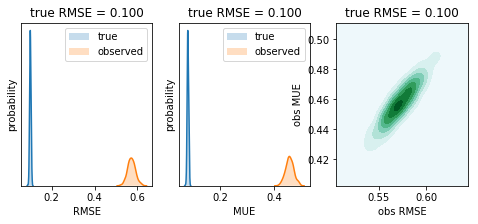

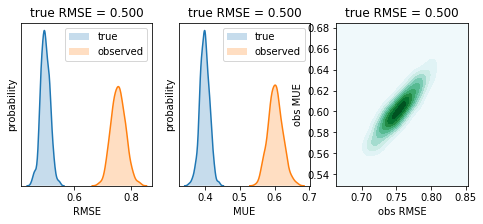

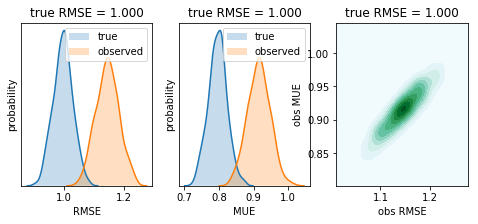

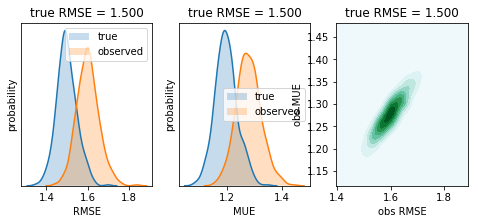

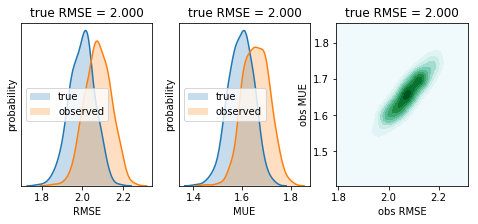

In [20]:
plot_statistics(rmse_true=0.1, sigma_exp=.4, sigma_calc=.4)
plot_statistics(rmse_true=0.5, sigma_exp=.4, sigma_calc=.4)
plot_statistics(rmse_true=1.0, sigma_exp=.4, sigma_calc=.4)
plot_statistics(rmse_true=1.5, sigma_exp=.4, sigma_calc=.4)
plot_statistics(rmse_true=2.0, sigma_exp=.4, sigma_calc=.4)

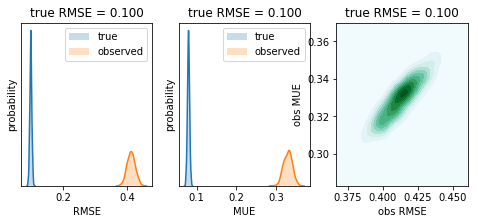

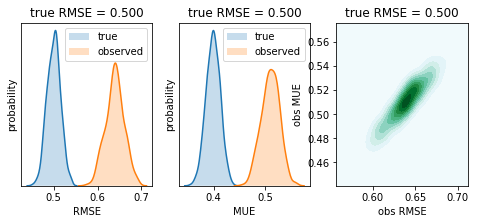

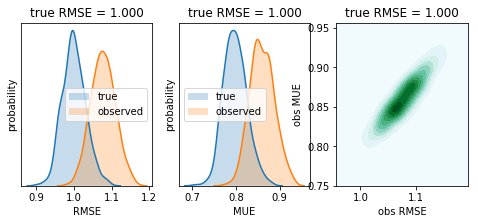

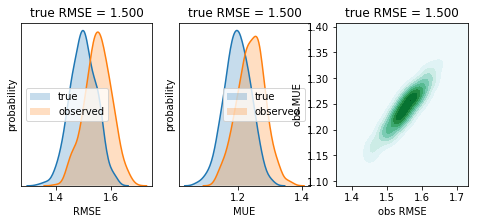

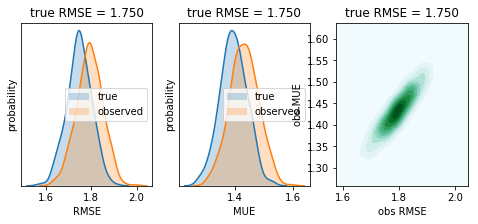

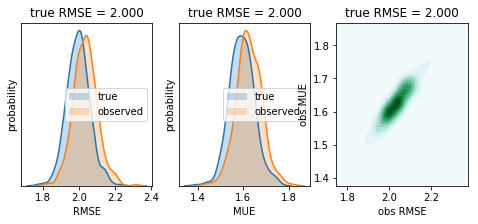

In [21]:
plot_statistics(rmse_true=0.1, sigma_exp=.4, sigma_calc=0)
plot_statistics(rmse_true=0.5, sigma_exp=.4, sigma_calc=0)
plot_statistics(rmse_true=1.0, sigma_exp=.4, sigma_calc=0)
plot_statistics(rmse_true=1.5, sigma_exp=.4, sigma_calc=0)
plot_statistics(rmse_true=1.75, sigma_exp=.4, sigma_calc=0)
plot_statistics(rmse_true=2.0, sigma_exp=.4, sigma_calc=0)

# Can we jointly infer the results of both experiments?

Unfortunately, the ordering of mutations is not guaranteed to be the same in the two FEP+ and Prime datasets, so the most we can do is share general priors in our model. We can do better if we had the mutation data compiled in the same file.

In [22]:
DDG_FEP_exp_obs, DDG_FEP_obs, dDDG_FEP_obs = read_fep_data('results/All_144_v173_all5ns.KeepLOD.dat')
[nmutants, nreplicates] = DDG_FEP_obs.shape
print(DDG_FEP_exp_obs.shape)

DDG_prime_exp_obs, DDG_prime_calc_obs = read_gbsa_data('results/All_144_Prime.dat')
print(DDG_prime_exp_obs.shape)

(142,)
(142,)


In [23]:
# Build the Bayesian model for both FEP+ and Prime, sharing priors where possible

joint_model = pm.Model()

with joint_model:
    # Priors on nuisance parameters (that will be marginalized out)
    mu_mut = pm.Uniform('mu_mut', -6, +6) # kcal/mol
    sigma_mut = pm.HalfFlat('sigma_mut', testval=1) # kcal/mol
        
    DDG_FEP_true = pm.Normal('DDG_FEP_true', mu=mu_mut, sd=sigma_mut, shape=nmutants)    
    DDG_prime_true = pm.Normal('DDG_prime_true', mu=mu_mut, sd=sigma_mut, shape=nmutants)    
    
    # Priors on unknown values of interest
    RMSE_FEP_true = pm.HalfFlat('RMSE_FEP', testval=1) # kcal/mol, uninformative prior for nonnegative values of the RMSE
    MUE_FEP_true = pm.Deterministic('MUE_FEP', RMSE_FEP_true*np.sqrt(2.0/np.pi)) # store MUE estimate alongside RMSE using analytical relationship
    RMSE_prime_true = pm.HalfFlat('RMSE_prime', testval=1) # kcal/mol, uninformative prior for nonnegative values of the RMSE
    MUE_prime_true = pm.Deterministic('MUE_prime', RMSE_prime_true*np.sqrt(2.0/np.pi)) # store MUE estimate alongside RMSE using analytical relationship
    
    # Unknown true computed values
    DDG_FEP_calc_true = pm.Normal('DDG_FEP_calc_true', mu=(DDG_FEP_true), sd=RMSE_FEP_true, shape=nmutants)    
    
    # Data likelihood for observed data
    DDG_FEP_exp = pm.Normal('DDG_FEP_exp', mu=DDG_FEP_true, sd=sigma_exp, shape=nmutants, observed=DDG_FEP_exp_obs)
    DDG_FEP = list()
    for replicate in range(nreplicates):
        DDG_FEP.append(pm.Normal('DDG_FEP_%d' % replicate, mu=DDG_FEP_calc_true, sd=dDDG_FEP_obs[:,replicate], shape=nmutants, observed=DDG_FEP_obs[:,replicate]))

    # Data likelihood for observed data
    DDG_prime_exp = pm.Normal('DDG_prime_exp', mu=DDG_prime_true, sd=sigma_exp, shape=nmutants, observed=DDG_prime_exp_obs)
    DDG_prime_calc_true = pm.Normal('DDG_prime_calc_true', mu=(DDG_prime_true), sd=RMSE_prime_true, shape=nmutants, observed=DDG_prime_calc_obs)    
    

In [24]:
# Sample from the posterior and plot the RMSE confidence interval
with joint_model:
    trace = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:19<00:00, 288.30it/s]


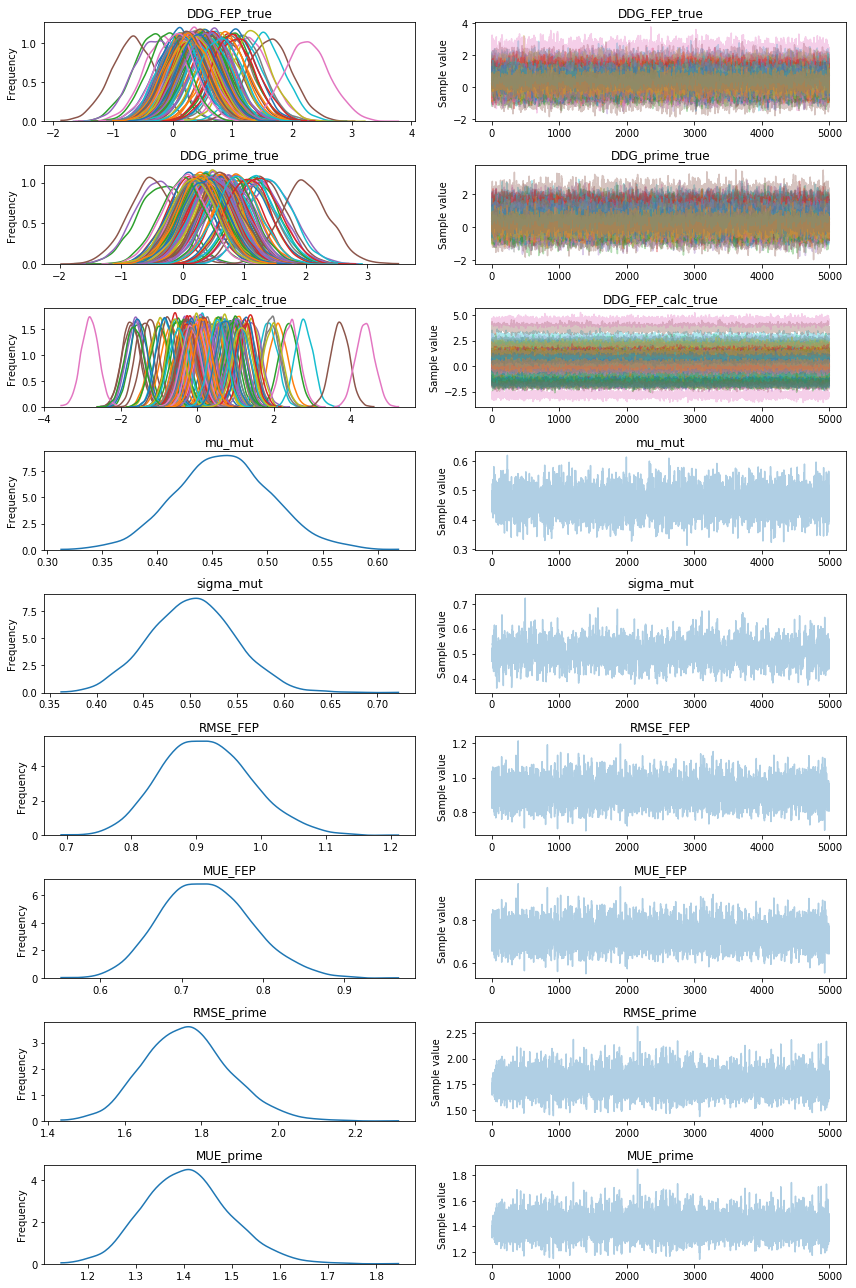

In [25]:
# Plot the posterior confidence interval for RMSE
_ = pm.traceplot(trace)

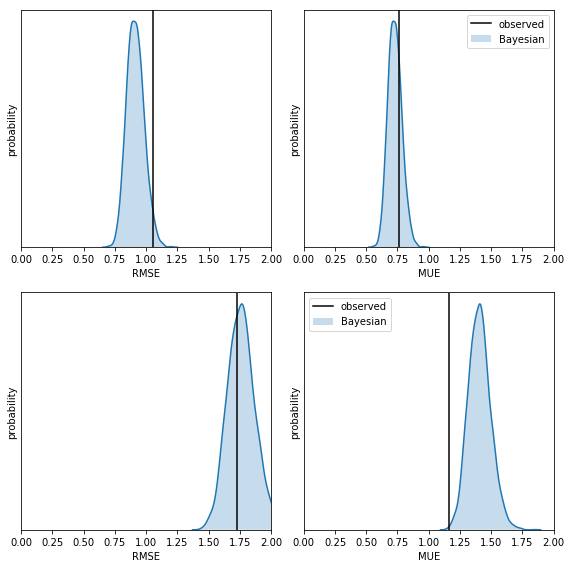

In [26]:
# Plot the Bayesian confidence intervals for the RMSE and MUE
plt.figure(figsize=[8,8]);

# RMSE
RMSE_obs = np.sqrt(np.mean((DDG_FEP_exp_obs - DDG_FEP_obs.mean(1))**2))
plt.subplot(221);
sns.kdeplot(trace['RMSE_FEP'], shade=True);
plt.plot([RMSE_obs, RMSE_obs], [0, 10], 'k-');
#plt.legend(['observed', 'Bayesian']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);
plt.xlim([0, 2])

# MUE
plt.subplot(222);
MUE_obs = np.mean(np.abs((DDG_FEP_exp_obs - DDG_FEP_obs.mean(1))))
sns.kdeplot(trace['MUE_FEP'], shade=True);
plt.plot([MUE_obs, MUE_obs], [0, 10], 'k-');
plt.legend(['observed', 'Bayesian']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);   
plt.xlim([0, 2])

# RMSE
RMSE_obs = np.sqrt(np.mean((DDG_prime_exp_obs - DDG_prime_calc_obs)**2))
plt.subplot(223);
sns.kdeplot(trace['RMSE_prime'], shade=True);
plt.plot([RMSE_obs, RMSE_obs], [0, 10], 'k-');
#plt.legend(['observed', 'Bayesian']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);
plt.xlim([0, 2])


# MUE
plt.subplot(224);
MUE_obs = np.mean(np.abs((DDG_prime_exp_obs - DDG_prime_calc_obs)))
sns.kdeplot(trace['MUE_prime'], shade=True);
plt.plot([MUE_obs, MUE_obs], [0, 10], 'k-');
plt.legend(['observed', 'Bayesian']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);  
plt.xlim([0, 2])

plt.tight_layout()